c:\Users\17075\Desktop\Code for beginner\Projects\capstone-CCBER\Preprocessing-Landmarks\bee_wing_photos_isolated


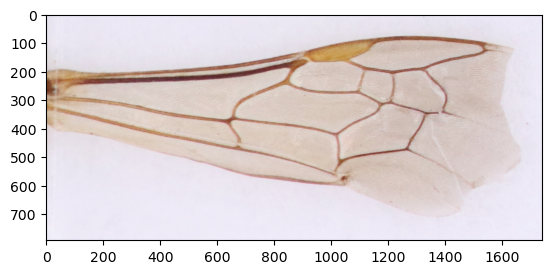

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torchvision 
from PIL import Image 
import cv2  

images = []
#make sure data  bee_wing_photos_isolated is inside this folder
file_path2 = os.path.join(os.getcwd(), 'bee_wing_photos_isolated')
print(file_path2)

class CCBER_BEES(torch.utils.data.Dataset):
    def __init__(self, data_path, transform = None):
        images = []
        for species_name in os.listdir(data_path):
            species_path = os.path.join(data_path, species_name)
            for image_name in os.listdir(species_path):
                if image_name.endswith(".JPG"):   
                    image_path = os.path.join(species_path,image_name)   
                    images.append(image_path)
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_file = self.images[index]
        image = Image.open(image_file).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
    
data2 = CCBER_BEES(file_path2)

rand = data2.images[np.random.randint(0, len(data2))]
test_image = cv2.imread(rand) 


plt.imshow(test_image[:,:,::-1])


original image shape: (198, 436, 3)


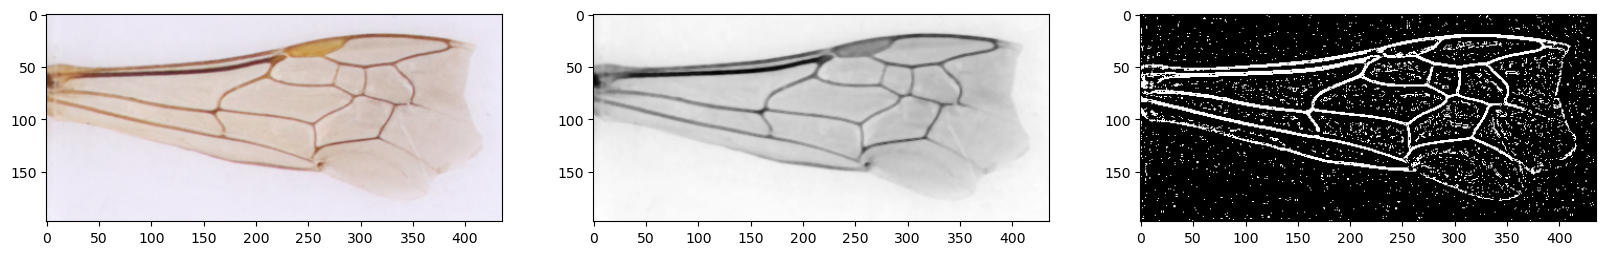

In [4]:

image_chosen = test_image.copy()
image_chosen = cv2.pyrDown(image_chosen)
image_chosen = cv2.pyrDown(image_chosen)

#Original Image
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
plt.imshow(image_chosen[:,:,::-1])
print('original image shape:',image_chosen.shape)

#gray scale + bluring
image_chosen_gray = cv2.cvtColor(image_chosen, cv2.COLOR_BGR2GRAY)
image_chosen_gray_blur = cv2.bilateralFilter(image_chosen_gray, 3, 50, 50)
image_chosen_gray_blur = cv2.medianBlur(image_chosen_gray_blur,3)
plt.subplot(3,3,2)
plt.imshow(image_chosen_gray_blur, cmap='gray')

#adaptive thresholding step 2
th = cv2.adaptiveThreshold(image_chosen_gray_blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,3,1,)
plt.subplot(3,3,3)
plt.imshow(th, cmap='gray')



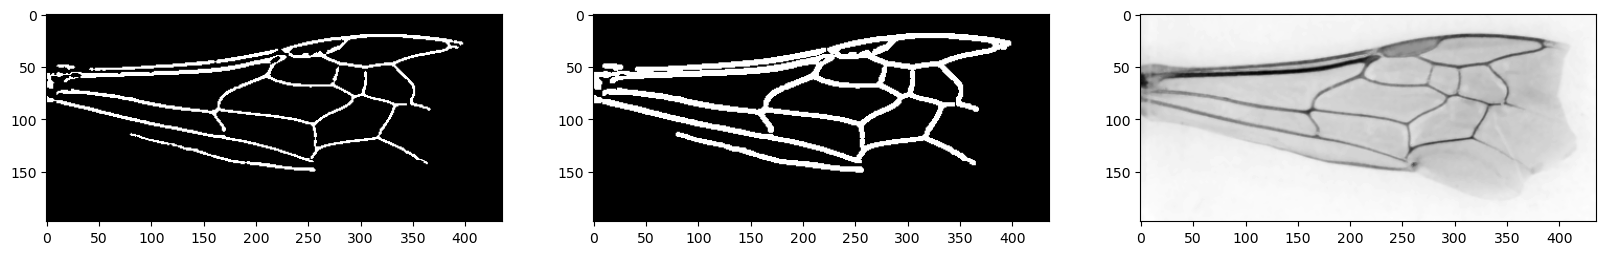

In [5]:
plt.figure(figsize=(20,20))
#Noise reduce and dilation: step 3
noise_remove = th.copy()
noise_remove = cv2.medianBlur(noise_remove, 3)

contours, _ = cv2.findContours(noise_remove, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE,)
filtered_contours = [i for i in contours if cv2.contourArea(i) < 30]
noise_remove = cv2.drawContours(noise_remove, filtered_contours, -1, 0, cv2.FILLED)




plt.subplot(3,3,4)
plt.imshow(noise_remove, cmap='gray')
kernel = np.full((3,3), 255)
noise_remove = cv2.dilate(noise_remove, kernel)

plt.subplot(3,3,5)
plt.imshow(noise_remove, cmap='gray')

### return by grayscale!!
sharpened_image = np.zeros_like(image_chosen_gray)
sharpened_image[noise_remove == 255] = image_chosen_gray[noise_remove == 255]
sharpened_image[noise_remove == 0] = image_chosen_gray_blur[noise_remove == 0]

plt.subplot(3,3,6)
plt.imshow(sharpened_image, cmap='gray')



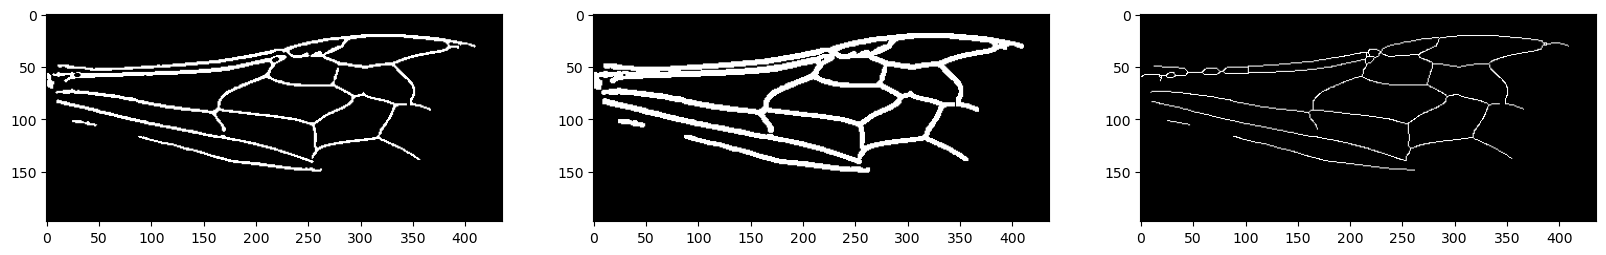

In [6]:
plt.figure(figsize=(20,20))

#Repeat step 2 and 3 

sharpened_image = cv2.GaussianBlur(sharpened_image, (3,3), 0)

th = cv2.adaptiveThreshold(sharpened_image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,3,1,)
noise_remove = th.copy()

noise_remove = cv2.medianBlur(noise_remove, 3)
contours, _ = cv2.findContours(noise_remove, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE,)
filtered_contours = [i for i in contours if cv2.contourArea(i) < 30]
noise_remove = cv2.drawContours(noise_remove, filtered_contours, -1, 0, cv2.FILLED)

plt.subplot(3,3,7)
plt.imshow(noise_remove, cmap='gray')


noise_remove = cv2.dilate(noise_remove, np.full((3,3),255))

#noise_remove = cv2.GaussianBlur(noise_remove, (3,3), 0)

plt.subplot(3,3,8)
plt.imshow(noise_remove, cmap='gray')

## thinning, zhangSuen, https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm

from thin import zhangSuen, get_corners
skinny = zhangSuen(noise_remove/255) * 255
skinny = skinny.astype('uint8')
#skinny = cv2.cvtColor(skinny, cv2.COLOR_BGR2HSV)
plt.subplot(3,3,9)
plt.imshow(skinny, cmap='gray')


#corn = get_corners(skinny)
#plt.subplot(3,3,9)
#plt.imshow(corn, cmap='gray')

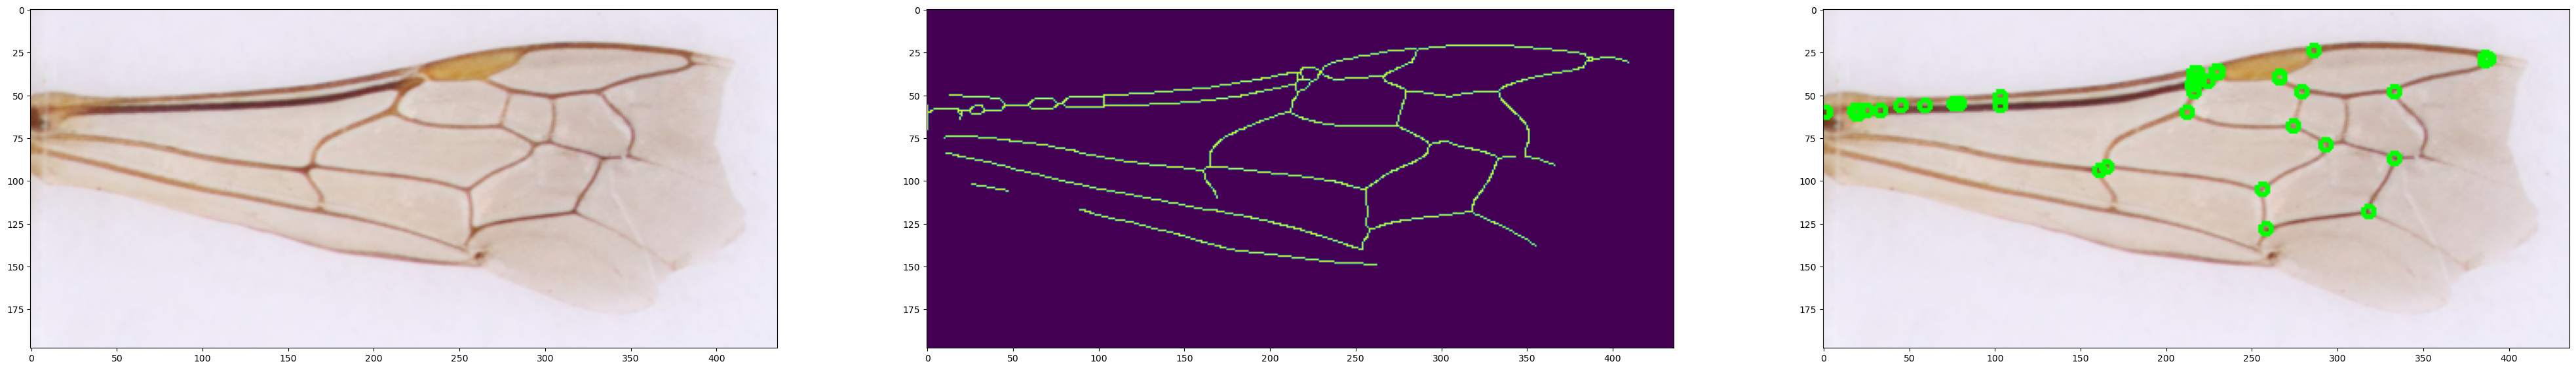

In [7]:
plt.figure(figsize=(50,50))
corn = get_corners(skinny)

image_colored = image_chosen.copy()

plt.subplot(1,3,1)
plt.imshow(image_colored[:,:,::-1])


for c in np.argwhere(corn):
    cv2.circle(image_colored, c[::-1], 3, (0,255,0), 2, lineType=cv2.FILLED)

    
plt.subplot(1,3,2)
plt.imshow(skinny)
 
plt.subplot(1,3,3)
plt.imshow(image_colored[:,:,::-1])

